# Interpretación

Tal como se mencionó anteriormente, uno de los _trade-off_ de los ensambles de árboles es que al agrupar múltiples árboles el modelo en conjunto deja de ser interpretable. Esto puede no suponer un problema si el objetivo es predecir, pero si el objetivo es interpretar el modelo el hecho de trabajar con 'cajas negras' puede ser un problema.

Es por ello que se desarrollaron técnicas para extraer información de modelos de aprendizaje automático. Estas técnicas se aplican una vez entrenado el modelo y permiten entender cómo el mismo utiliza las variables. Pese a que existes distintas técnicas para interpretar modelos, algunas son específicas para ciertos tipos de modelos mientras que otras son específicas, en este trabajo se estudiará como acceder a la importancia de cada covariable y al efecto que tiene cada una de ellas sobre la variable dependiente.

## Importancia de las variables



Con el acceso a información que se tiene actualmente, no es extraño querer incluir múltiples covariables en un mismo modelo. El problema, es que entender cuales de ellas realmente están aportando al mismo no es trivial. Por lo que se desarrollaron múltiples técnicas para evaluarlo, todas con sus argumentos a favor y en contra.

En este trabajo nos centramos en dos: split gain feature imporatnce and permutation feature importance.

### Split Importance

Esta técnica fue propuesta por [@friedman_2001] y asignar importancias en base a la cantidad de _splits_ que cada variable tiene en el árbol. Esta metodología solamente se puede aplicar para árboles de decisión y más formalmente se ve para un solo árbol:
 
$$
\hat{I}_j^{2}(T)=\sum_{t=1}^{j-1}\hat{i}_t^{2}1(v_t=1)
$$ {#eq-split_importance}

done $I$ es la influencia para el nodo $j$ del árbol $T$, siento $v$ la _splitting variable_ que se suma por todos los nodos no terminales.

La @eq-split_importance es calculada para un solo árbol. Por lo que cuando se trabaja con ensambles de árboles se debe generalizar a

$$
\hat{\mathbf{I}}_j^{2}=\frac{1}{B}\sum_{m=1}^{B}\hat{I}^{2}_j(T_b)
$$

Intuitivamente, se puede entender como el promedio de los _splits_ de cada variable. Sin embargo, esta medida esta basada en heurísticas y no contiene fundamentos estadísticos sólidos. Tal es así que fue criticada por [@zhou2020] y [@strobl_2008] por dar demasiada influencia a variables correlacionadas y favorecer variables categóricas con muchas categorias.

El problema de las variables correlacionadas radica en que el modelo no puede distinguir entre aquellas variables que realmente aportan a la generación de los datos con las que simplmenente correlacionan con variables influyentes, por lo que termina asignando mayor influencia a variables que no deberían tenerla.

En el caso de las variables categóricas, este método prioriza aquellas variables que son propensas a tener muchos _splits_, sin que esto siginifique que las variables son importantes o estan reduciendo el error.

### Permutation Feature Importance

Otra alternativa para calcular las importancias de las variables es uilizar _Permutation feature Importance_ (PFI), técnica desarrollada por [@breiman2001a] exclusivamente para _Random Forest_ que luego fue generalizada para cualquier modelo [@fisher2019]. Estas técnicas se basan, intuitivamente, en entender cómo cambia la función de pérdida cuando se permutan las variables. Las variables más importantes serán aquellas que más cambien el error del modelo al ser permutadas.

Como se ve a continuación, si bien [@fisher] propone métodos para calcular la importancia en modelos de clasificación, se proesentará la adaptación a un modelo de regresión. Por lo que habiendo entrenado un modelo de _random forest_ $\hat{f}$ para cada covariable $j \in {1,2,...,J}$ se:
1. Construye un nuevo conjunto de datos $X_j$ permutando las observaciones de la covariable $j$ y dejando el resto de las observaciones fijas.
2. Entrena un nuevo modelo $\hat{f}_j$ utilizando el nuevo conjunto de datos $X_j$ y calcula el out-of-bag error.
$$
E_{OOB}(X_j) = \frac{1}{n} \sum_{i=1}^{n} \left( y_i -  \hat{f}^{(b)}(X_{i,j}) \right)^2
$$
3. Luego se compara el out-of-bag error con el error del modelo original y se calcula la diferencia mediante:
$$
PFI(j) = E_{OOB}(X_j) - E_{OOB}(X) ~~ \text{ó} ~~ PFI(j) = \frac{E_{OOB}(X_j)}{E_{OOB}(X)}
$$

Sin embargo, como se mencionó anteriormente este método para calcular importancias no es generalizable dado que utiliza los errores out-of-bag, por lo que un modelo que no utilice esta metodología no podría usarla. Sin embargo, es fácilmente extendible a dichos casos. A continuación se presenta la generalización propuesta en [@fisher2019].

Los autores se basan en la propuesta de [@breiman2001a], pero deciden llamar a la medida de importancia _Model Reliance_ (MR). Por lo que partiendo de un modelo entrenado $\hat{f}$, una variable de respuesta $y$, una función de pérdida $L$ y
una matriz de diseño $X$ con covariables $j \in {1,2,...,J}$, para cada covariable j se:
1. permuta la covariable j
2. Calculamos la pérdida
$$L_{perm}(f)= \mathcal{E}[L(f,(Y,X_1^{perm},X_2))]$$
donde se permutan los valores de $X_1$, dejando constantes las demás variables. 
3. se compara la perdida con el error original
$$
MR^{j}(f)=\frac{L^{j}_{perm}(f)}{L(f)}
$$

De esta forma se obtiene cuanto afecta cada covariable a la variable de respuesta.

Para calcular $L_{perm}$ los autores proponen dos alternativas,
1. Realizar una permutación por todas las observaciones
$$
\hat{e}_{perm}(F)\frac{1}{n(n-1)}\sum_{i=1}^n\sum_{j\neq i}L\{f,y_j,X_{1[i,.]},X_{2[i,.]} \}
$$
Sin embargo esto puede ser computacionalmente muy peasado, por lo que proponen como alternativa
2. Dividir la muestra a la mitad y reemplazar los valores de $X_1$ de la primera mitad con los de la segunda y vice versa.
$$
\begin{aligned}
\hat{e}_{\text{divide}}(f) &= \frac{1}{2 \lfloor n/2 \rfloor} \sum_{i=1}^{\lfloor n/2 \rfloor} \left[
L\Bigl(f,\Bigl(y_{[i]},\, X_{1\bigl[i+\lfloor n/2 \rfloor\bigr]},\, X_{2[i]}\Bigr)\Bigr) \right. \\
&\left. \quad + L\Bigl(f,\Bigl(y_{i+\lfloor n/2 \rfloor},\, X_{1[i]},\, X_{2\bigl[i+\lfloor n/2 \rfloor\bigr]}\Bigr)\Bigr)
\right].
\end{aligned}
$$


### Model Class Reliance

Un problema común a la hora de calcular importancias es que el modelo que terminamos usando se decide únicamente en función de una métrica de error. Esto no supondría inconvenientes si las importancias de los modelos fueran parecidas. Sin embargo, suele pasar que para muchos modelos con un poder predictivo similar las importancias de las variables cambien. A continuación se presenta un ejemplo en el cual se entrenaron múltiples _Gradient Boosting Machines_ con diferentes combinaciones de hiperparámetros, eligiendo las combinaciones que minimicen el error cuadrático medio. Para el elegir dicha combinación se utilizó validación cruzada con $k=5$. El conjunto de datos para este ejemplo en particular fue _Abalone_ [@abalone_1] donde se busca predecir la edad del Abalone en función de distintas características.

In [10]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import tqdm

np.random.seed(73815)
n = 1000

# Generate all X features at once
X = np.random.uniform(0, 1, (n, 10))
X_cols = [f'X_{i+1}' for i in range(10)]

# Calculate y using a mix of original and redundant features
# Different models might prefer different combinations of these features

y = (X[:, 0]**2 + np.sin(X[:, 1]) - np.exp(X[:, 2]) + np.log1p(X[:, 3]) + 
     X[:, 4]*X[:, 5] + X[:, 6]*X[:, 7]*X[:, 8] - np.sqrt(X[:, 9]) + 

     (X[:, 0]**2 + np.random.normal(0, 0.05, n)) + (np.sin(X[:, 1])+np.random.normal(0, 0.05, n))
     - (np.exp(X[:, 2])+np.random.normal(0, 0.05, n)) + (np.log1p(X[:, 3])+np.random.normal(0, 0.05, n))
     
     + np.random.normal(0, 0.1, n))

# Create DataFrame with all columns
df = pd.DataFrame(X, columns=X_cols)
df['y'] = y

from sklearn.model_selection import train_test_split
X = df.drop(columns='y')

y = df['y']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
#| label: set-up

import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split

# Fetch the abalone dataset
abalone = fetch_ucirepo(id=1)

# Prepare features and targets: drop the 'Sex' column and ensure y is 1D.
X = abalone.data.features.drop('Sex', axis=1)
# Convert y to a 1D array (using .values.ravel() or .squeeze())
y = abalone.data.targets.values.ravel() if hasattr(abalone.data.targets, 'values') else abalone.data.targets.squeeze()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
#| label: run-gbm

from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
# Define parameter grid
param_grid = {
    'n_estimators': [i for i in range(100, 1000, 100)],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4,5],
    'loss': ['squared_error', 'absolute_error', 'huber']
}

# Calculate total iterations = number of parameter combinations * number of CV folds
n_candidates = len(list(ParameterGrid(param_grid)))
cv_folds = 5  # as specified in GridSearchCV
total_iterations = n_candidates * cv_folds

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    cv=cv_folds,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0  # disable default verbose output
)
grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [13]:
#| label: calculate-importances

# Best model from grid search
rf1 = grid_search.best_estimator_

# Number of top models to evaluate
N = 15  # You can change this to any number

# Get the top N best parameter sets from grid search results
top_params = pd.DataFrame(grid_search.cv_results_)
top_params = top_params.sort_values('rank_test_score').iloc[:N]

# Create dictionaries to store models and their CV errors
models = {}
rmse_values = {}

# Best model
models['RF1'] = rf1
# Convert negative MSE to RMSE (GridSearchCV uses negative scores for maximization)
rmse_values['RF1'] = np.sqrt(-top_params.iloc[0]['mean_test_score'])

# Loop through the top parameter sets (2nd to Nth best)
for i in range(1, N):
    model_name = f'RF{i+1}'
    
    # Create model with the current parameter set
    model = GradientBoostingRegressor(random_state=42, **top_params.iloc[i]['params'])
    
    # Store model
    models[model_name] = model
    
    # Get CV error from grid search results
    rmse = np.sqrt(-top_params.iloc[i]['mean_test_score'])
    rmse_values[model_name] = rmse

Específicamente, para este ejemplo se entrenaron modelos con cantidad de árboles de 100 a 900 (con incrementos de 100), tasas de aprendizaje de 0.01, 0.05 y 0.1, profundidad máxima max_depth de 2, 3, 4 y 5, y funciones de pérdida de tipo pérdida cuadrática, error absoluto y Huber. Siendo un total de 324 modelos entrenados. En la @tbl-display-importances se pueden ver los 15 modelos que menor error tuvieron, junto con los hiperparámetros asociados. Puede verse claramente, como hay múltiples modelos que tienen una performance predictiva similar pero distintos hiperparámetros.

In [14]:
#| label: tbl-display-importances
#| tbl-cap: Hiperparámetros y errores de los 15 modelos entrenados con menor error de validación cruzada.
#| include: true

# Create a DataFrame to store optimal hyperparameters and RMSE for each model
model_info = []

for i, model_name in enumerate(models.keys()):
    # Get the model's hyperparameters
    if i == 0:  # RF1 is the best model from the grid search
        params = top_params.iloc[0]['params']
    else:
        params = top_params.iloc[i]['params']
    
    # Create a dictionary with model name, RMSE, and hyperparameters
    model_data = {
        'Model': model_name,
        'RMSE': rmse_values[model_name],
        **params  # Unpack the hyperparameters dictionary
    }
    
    model_info.append(model_data)

# Convert to DataFrame
model_summary_df = pd.DataFrame(model_info)

model_summary_df.columns = ['Modelo', 'RMSE', 'Shrinkage', 'Pérdida', 'Profundidad máx', 'Árboles']

model_summary_df['RMSE'] = model_summary_df['RMSE'].apply(lambda x: f"{x:.4f}")
model_summary_df['Shrinkage'] = model_summary_df['Shrinkage'].apply(lambda x: f"{x:.2f}")


display(model_summary_df.style.hide(axis='index'))


Modelo,RMSE,Shrinkage,Pérdida,Profundidad máx,Árboles
RF1,0.5637,0.10,absolute_error,2,900
RF2,0.5642,0.10,absolute_error,2,800
RF3,0.5661,0.10,absolute_error,2,700
RF4,0.5740,0.10,absolute_error,2,600
RF5,0.5774,0.10,absolute_error,2,500
RF6,0.5821,0.10,squared_error,2,900
RF7,0.5821,0.10,squared_error,2,800
RF8,0.5821,0.10,squared_error,2,700
RF9,0.5822,0.10,squared_error,2,600
RF10,0.5823,0.10,squared_error,2,500


In [17]:
#| label: calculate-permutation-importance

# Calculate permutation importance for each model
from sklearn.inspection import permutation_importance

# Fit models on the full training set for permutation importance
importances = {}
for name, model in models.items():
    if name != 'RF1':  # RF1 is already fitted
        model.fit(X_train, y_train)
    
    print(f"Calculating permutation importance for {name}...")
    result = permutation_importance(
        model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
    )
    importances[name] = result.importances_mean
    
# Create a DataFrame for feature importances
importance_df = pd.DataFrame(
    {name: imp for name, imp in importances.items()},
    index=X.columns
)

Calculating permutation importance for RF1...
Calculating permutation importance for RF2...
Calculating permutation importance for RF3...
Calculating permutation importance for RF4...
Calculating permutation importance for RF5...
Calculating permutation importance for RF6...
Calculating permutation importance for RF7...
Calculating permutation importance for RF8...
Calculating permutation importance for RF9...
Calculating permutation importance for RF10...
Calculating permutation importance for RF11...
Calculating permutation importance for RF12...
Calculating permutation importance for RF13...
Calculating permutation importance for RF14...
Calculating permutation importance for RF15...


Además, y posiblemente más preocupante, cuando vemos la @fig-plot-importances vemos como las importancias de las variables (calculadas mediante _Permutation Feature Importance_) varían entre modelos con un poder predictivo similar. Este mismo fenómeno puede verse también en la @fig-plot-heatmap donde para los distintos modelos las variables tienen rankings de importancia muy diferentes. El heatmap muestra claramente cómo una misma variable puede ser considerada la más importante (ranking 1) en un modelo, mientras que en otro puede tener una importancia mucho menor (ranking 5 o 6). Esta inconsistencia en la importancia de las variables entre modelos con rendimiento similar sugiere inestabilidad en la interpretación de los resultados a los que se puede llegar.

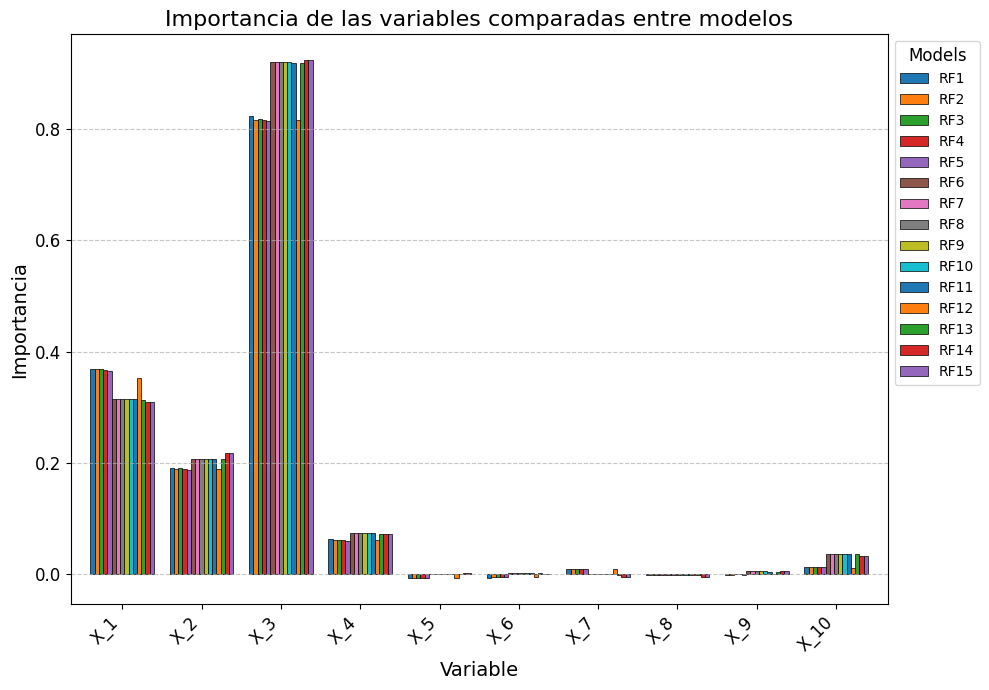

In [18]:
#| label: fig-plot-importances
#| fig-caption: Importancia de las variables comparadas entre modelos.
#| include: true

import matplotlib.pyplot as plt

# Visualize feature importances
# Create a better layout for feature importance visualization
fig, ax = plt.subplots(figsize=(10, 7))

# Plot with more distinct colors and thicker bars
importance_df.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', linewidth=0.5)

# Improve title and labels with better font sizes
plt.title('Importancia de las variables comparadas entre modelos', fontsize=16)
plt.ylabel('Importancia', fontsize=14)
plt.xlabel('Variable', fontsize=14)

# Improve readability of feature names
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend with better positioning
plt.legend(title='Models', title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# Ensure everything fits properly
plt.tight_layout()
plt.show()

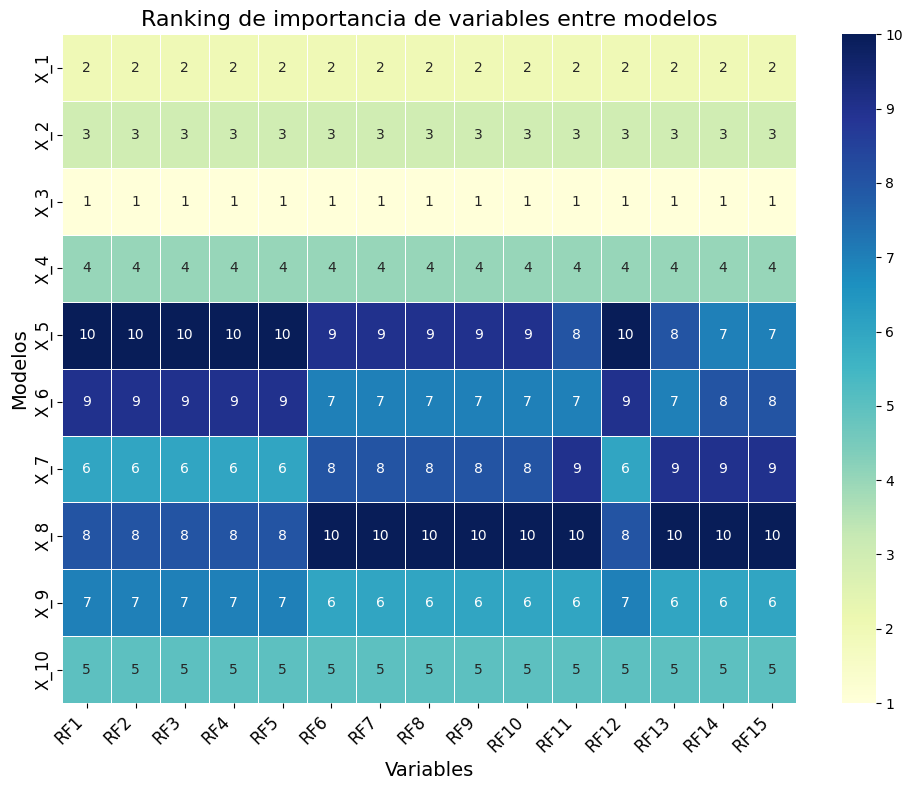

In [19]:
#| label: fig-plot-heatmap
#| fig-caption: Ranking de importancia de variables entre modelos.
#| include: true

# Heatmap to visualize differences in feature importance rankings
import seaborn as sns

# Crear un dataframe con los rankings de importancia (1 = más importante)
rank_df = importance_df.rank(ascending=False)

# Crear una figura con mejor tamaño
plt.figure(figsize=(10, 8))

# Crear el heatmap con colores más apropiados y anotaciones
sns.heatmap(rank_df, annot=True, cmap='YlGnBu', fmt='.0f', 
            linewidths=0.5, linecolor='white')

# Mejorar el título y etiquetas
plt.title('Ranking de importancia de variables entre modelos', fontsize=16)
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Modelos', fontsize=14)

# Ajustar tamaño de fuente para los ejes
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

# Asegurar que todo se ajuste correctamente
plt.tight_layout()
plt.show()

El fenómeno observado, donde múltiples modelos con similar capacidad predictiva asignan importancias sustancialmente diferentes a las variables, se conoce como el _Rashomon Effect_ en estadística [@breiman_2001]. Este término, inspirado en la película de Kurosawa donde un mismo evento es narrado desde perspectivas contradictorias es formalizado en [@fisher2019] como el "conjunto de Rashomon", definido como la colección de modelos con rendimiento predictivo similar pero con diferentes estructuras internas. Esta multiplicidad de explicaciones válidas representa un desafío fundamental para la interpretabilidad en _machine learning_, ya que sugiere que la importancia de una variable no es una propiedad intrínseca de los datos, sino que depende del modelo específico elegido.

Es por ello que los autores trabajaron sobre la _Model Class Reliance_ (MCR), que se basa en para una clase de modelos $\mathcal{F}$, MCR es el rango de todos los posibles valores de MR sobre modelos que tengan un poder predictivo similar al óptimo. Para lo cual, primero se define el "conjunto de Rashomon" como

$$
R(\epsilon)\{f\in\mathcal{f}|e_{orig}(f)\neq e_{orig}(f_{ref}) + epsilon   \}
$$

Este set contiene todos los modes cuya pérdida sea como mucho $\epsilon$ peor que el modelo que minimiza el error $f_{ref}$

Luego se define el intervalo MCR como

$$
[MCR^{-}(\epsilon), MCR^{+}(\epsilon)]=[\min_{f\in R(\epsilon)}MR(f), \max_{f\in R(\epsilon)}MR(f)]
$$

Este intervalo MCR proporciona información valiosa sobre la importancia de una variable en toda la clase de modelos.

#### Interpretación
Si $MCR^{-}(\epsilon)$ es mayor que 1, significa que todos los modelos "buenos" (dentro del conjunto de Rashomon) dependen de la variable más que del modelo de referencia, lo que sugiere que la variable es consistentemente importante. Por otro lado, si $MCR^{+}(\epsilon)$ es cercano a 1, indica que ningún modelo "bueno" depende fuertemente de esa variable.

La interpretación del MCR nos permite evaluar si la importancia de una variable es consistente a través de diferentes modelos o si es específica de una arquitectura particular. Un intervalo MCR estrecho sugiere que la importancia de la variable es estable en todos los modelos con buen rendimiento, mientras que un intervalo amplio indica que la importancia varía significativamente dependiendo del modelo elegido. Por ejemplo, pueden ocurrir casos donde para una variable $J$ el $MCR^{-}(\epsilon)$ sea cercano a 1 pero $MCR^{+}(\epsilon)$ no. Esto indicaría existen modelos con buena capacidad predictiva que no dependen de la variable $J$ por lo que dicha variable no sería tan importante.

#### Estimación
En la práctica para estimar MCR se utiliza un estimador _plug-in_, es decir se calcula $\hat{MR}(f)$ para todos los modelos que integren el conjunto Rashomon empírico $\hat{R}(\epsilon)$.

## Efecto de las variables

Otra técnica útil para interpretar modelos de árboles es mediante _Partial Dependence Plots_. Los mismos también fueron introducidos por [@friedman_2001], donde los plantea como una técnica para aislar el efecto de una covariable sobre la variable de respuesta, más formalmente lo que se busca estimar es:

$$
\bar{f}(X_z)=\mathcal{E}_{x_l}[\hat{f}(x)]=\int \hat{F}(z,x_l)p(x_l)dx_l
$$ {#eq-pdp}

donde $\hat{f}(x)$ es el modelo entrenado, $z$ es el subset de variables a las que queremos estimar el efecto, $x_l$ representa todas las otras predicciones (que se mantienen constantes), $p(x_l)$ es la distribución conjunta de todas las otras variables y $\mathcal{E}_{x_l}[.]$ es la esperanza sobre la distribución $x_l$

Sin embargo, en la práctica es raro conocer $p(x_l)$ por lo que se utiliza el siguiente procedimiento:
 
$$
\bar{f}(z)\approx\frac{1}{n}\sum_{i=1}^{n}\hat{f}(z,x_l^{i})
$$

Cuyo algoritmo sería:
1. Para cada observación $i$ en la muestra, se toman los valores originales de las variables no seleccionadas $x_l^{i}$
2. Se utilizan los valores modificados de las variables z en cada $x_l^{i}$ dentro del modelo $\hat{F}$ para obtener las predicciones $\hat F(z,x_l^{i})$
3. Se promedian las predicciones para $i=1,2,...,n$

Cabe aclarar que al modificar solamente una variable y dejar el resto como estaban, se esta asumiendo que las variables $z$ son independientes a todo el resto. Algo que puede o no ser cierto dependiendo de la naturaleza de los datos. Además, al cambiar los valores de las variables a evaluar se podrían dar combinaciones poco realistas en la practica.

Con el fin de ejemplificar los gráficos de dependencia parcial se entrenó un modelo de _Gradient Boosting Machine_ con 100 árboles con el fin de predecir la edad del _Abalone_ en función de distintas medidas físicas. Una vez entrenado el modelo, se puede ver en la @fig-plot-impacts el efecto del peso total en la edad.

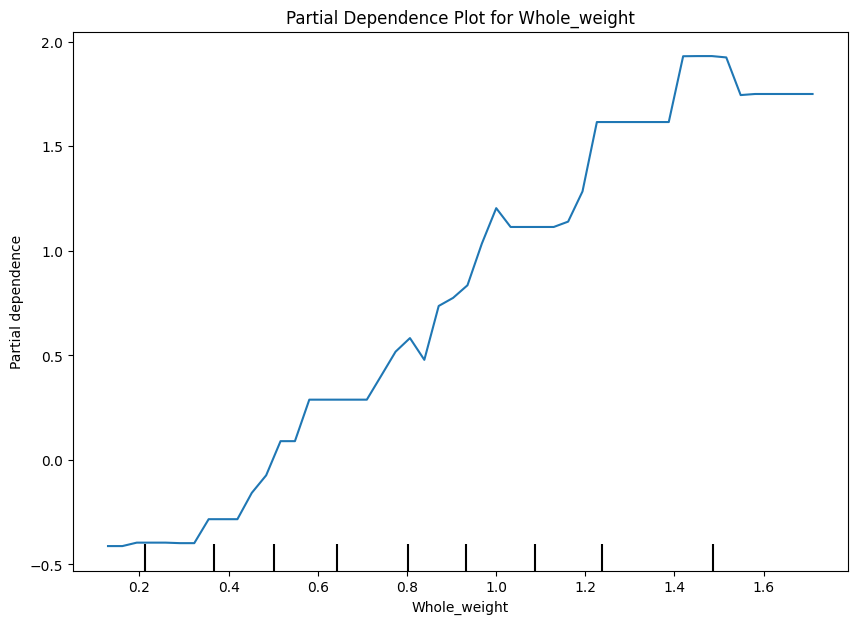

In [48]:
#| label: fig-plot-impacts
#| fig-caption: Efecto de las variables.
#| include: true

from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

# Fit the model
fitted_gbm = GradientBoostingRegressor(random_state=42)
fitted_gbm.fit(X_train, y_train)

# Create and display partial dependence plot
fig, ax = plt.subplots(figsize=(10, 7))
feature_name = X_train.columns[3]  # First feature

# Using PartialDependenceDisplay for modern implementation
display = PartialDependenceDisplay.from_estimator(
    fitted_gbm,
    X_train,
    [feature_name], 
    ax=ax,
    grid_resolution=50,  # Smoothness of the curve
    random_state=42
)

# Customize the plot
ax.grid(True)
ax.set_title(f'Partial Dependence Plot for {feature_name}')
plt.show()


Sin emabargo, como se mencionó anteriormente, los PDPs sufren problemas cuando las variables no son independientes. Para solventar esto, se puede utilizar el método de _Individual Conditional Expectation_ (ICE) que consiste en calcular el PDP para cada observación en la muestra.

### _Individual Conditional Expectation (ICE)_

Los _ICE_ fueron introducidos por [@Goldstein02015] como una técnica para estimar el efecto de una covariable sobre la variable de respuesta, más formalmente lo que se busca estimar es:

$$
f_i(x_z)=E[Y|X_z=x_z,X_{-z}=x_{-z}^{i}]
$$

Es decir, en lugar de calcular el efecto promedio de $z$ sobre $y$ calculando el promedio de $f(z,x_{-z})$ para todas las observaciones, se calcula el efecto de $z$ para cada observación $i$ manteniendo el resto de las variables constantes. De esta manera se puede obtener una estimación del efecto de $z$ para cada observación y no solo un promedio, teniendo así una visión más detallada.

De esta forma, se podrían entender los PDPs como el promedio de los ICE. Dado que mientras el primero se calcula mediante la distribución marginal de las variables, los segundos lo hacen utilizando la distribución condicional.

Cabe destacar que PDP y ICE deberían ser similares cuando las variables son independientes, pero cuando las variables no son independientes, los ICE pueden variar mucho por lo que se recomienda utilizar las dos técnicas.

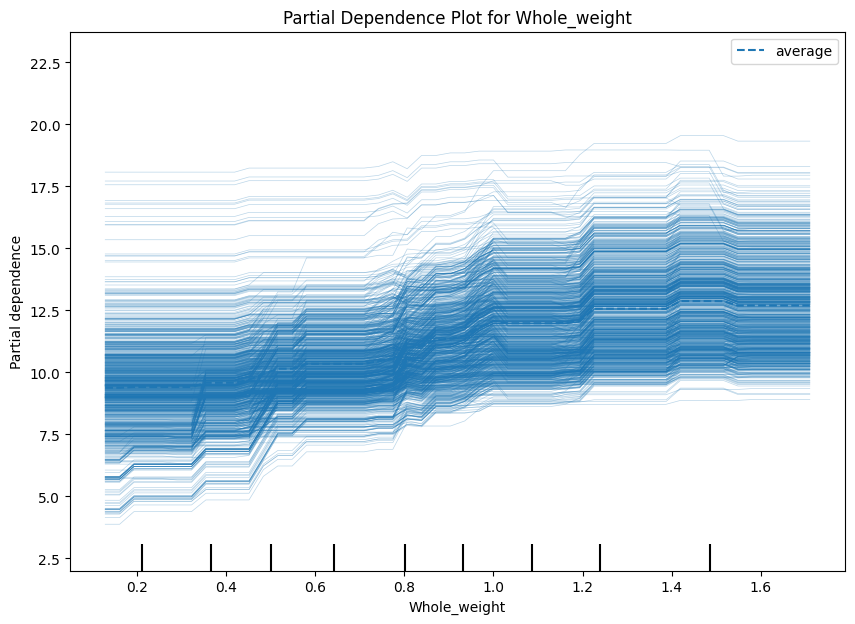

In [ ]:
#| label: fig-plot-ice
#| fig-caption: ICE y PDP.
#| include: true

import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay


# Create and display partial dependence plot
fig, ax = plt.subplots(figsize=(10, 7))
feature_name = X_train.columns[3]  # First feature

# Using PartialDependenceDisplay for modern implementation
display = PartialDependenceDisplay.from_estimator(
    fitted_gbm,
    X_train,
    [feature_name], 
    ax=ax,
    kind='individual',
    grid_resolution=50,  # Smoothness of the curve
    random_state=42
)

# Customize the plot
ax.grid(True)
ax.set_title(f'Partial Dependence Plot for {feature_name}')
plt.show()

Como se puede ver en la @fig-plot-ice, los ICE son mucho más variables que los PDP, lo que permite tener una visión más detallada del efecto de la variable en cuestión. Sin embargo, se puede ver que los ICE tienen distintas ordenadas al origen, lo que dificulta la comparación entre distintas variables y la identificación de efectos heterogéneos.

Para solventar este problema, se puede utilizar el método de _Centered ICE_ que consiste en centrar los ICE en algún punto de la distribución de la variable (los autores de este método sugieren el valor mínimo o máximo de la variable para tener gráficos sencillos de interpretar). Más formalmente se busca centrar cada curva $\hat{f}_i$ en un valor de referencia $(x^*,x_{ci})$ tal que:

$$
\hat{f}_{cent}^{(i)}=\hat{f}^{(i)}-1\hat{f}(x^*,x_{ci})
$$

A modo de ejemplo, si $x^*$ es el valor mínimo de $x_s$ todas las curvas empiezan en cero, por otro lado si es el máximo se puede ver ver el efecto acumulado de $x_s$ sobre $\hat{f}$ relativo al caso base.

A modo de ejemplo, en la @fig-plot-centered-ice se puede ver el _Centered ICE_ para la misma variable de antes. En este caso $x^*$ es el valor mínimo por lo que todas las curvas empiezan en cero. También, se puede ver en rojo la curva de PDP centrada.

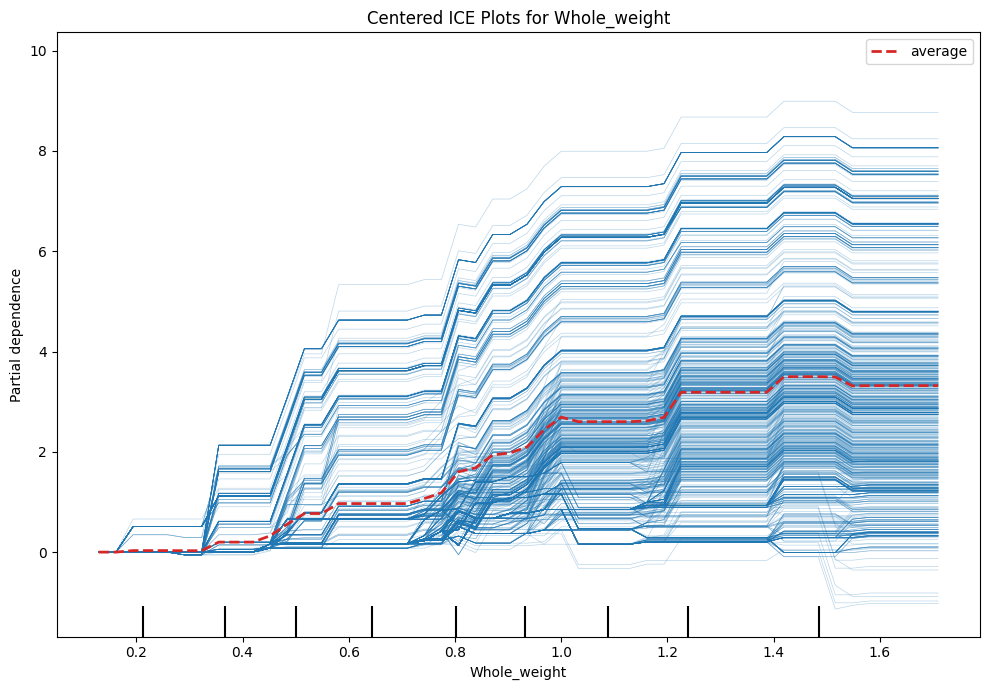

In [51]:
#| label: fig-plot-centered-ice
#| fig-caption: Gráficos de ICE centrados.
#| include: true

# Let's also create a centered ICE plot to better visualize the differences
fig, ax = plt.subplots(figsize=(10, 7))

# Centered ICE plot
display_centered = PartialDependenceDisplay.from_estimator(
    fitted_gbm,
    X_train,
    [feature_name], 
    kind='both',  # Shows both ICE and PDP
    centered=True,  # Centers the ICE curves
    ax=ax,
    grid_resolution=50,
    random_state=42,
    ice_lines_kw={'alpha': 0.3, 'color': 'tab:blue'},
    pd_line_kw={'color': 'tab:red', 'linewidth': 2}
)

ax.set_title(f'Centered ICE Plots for {feature_name}')
ax.grid(True)
plt.tight_layout()
plt.show()


### _Derivative ICE_

Con el fin de seguir identificando las interacciones entre las variables los autores proponen calcular los gráficos de la derivada parcial de $\hat{f}$ con respecto a $x_s$. A modo de formalizarlo, se asume independencia entre $x_s$ y el resto de las covariables, por lo que $\hat{f}$ puede ser escrita como:

$$
\hat{f}(x)=\hat{f}(x_s,x_c)=g(x_s)+h(x_c) \Rightarrow \frac{\partial \hat{f}(x)}{\partial x_s}=g'(x_s)
$$

lo cual significa que la relación entre $x_s$ y $\hat{f}$ no depende de $x_c$. Cuando esto se cumple todas las líneas deberían ser equivalentes.

### Causalidad

Pese a que [@pearl2018] menciona por qué los modelos de aprendizaje automático no pueden ser utilizados para hacer inferencia causal, dado que todos estos modelos se basan en el nivel de asociación entre variables, sin llegar a la intervención o contrafactuales. Sin embargo, [@Zhao2021] plantea que los PDPs y ICEs bajo ciertas condiciones pueden tener una interpretación en causal.

Los autores se basan en que @eq-pdp es igual al _backdoor adjustment_ definido por [@Pearl1993] como
$$
P(Y|do(X_s=x_s))=\int P(Y|X_s=x_s, X_c=x_c)dP(x_c)
$$ {#eq-back-door}

donde $P(Y|do(X_s=x_s))$ se refiere a la distribución de $Y$ luego de hacer un intervención en $X_s$. Esta formula permite identificar el efecto causal de $X_s$ en $Y$ siempre y cuando se cumpla cuando (1) ningún nodo $X_c$ sea dependiente descendiente de $X_s$ y (2) que $X_c$ 'bloquee' cualquier camino "back-door" entre $X_s$ e $Y$ que se puede pensar intuitivamente como una causa común entre $X_s$ e $Y$ que impide entender el efecto causal de $X_s$.

$$
E[Y|do(X_s=x_s)]=\int E[Y|X_s=x_s, X_c=x_c]dP(x_c)
$$ {#eq-back-door-expectation}

Ahora si partimos de $\hat{f}(x)$ la función aprendida por el modelo, que aproxima la expectativa condicional, es decir,  
$$
\hat{f}(x) \approx E[Y \mid X=x].
$$

asumiendo que el modelo está bien calibrado, es decir,  
$$
\hat{f}(x_S, x_C) = E[Y \mid X_S = x_S, X_C = x_C],
$$

podemos vincular ambas expresiones de la siguiente forma:  

$$
\begin{aligned}
\text{PDP}(x_S) &= \int \hat{f}(x_S, x_C) \, dP(x_C) \\
                &= \int E[Y \mid X_S = x_S, X_C = x_C] \, dP(x_C) \\
                &= E[Y \mid do(X_S = x_S)].
\end{aligned}
$$

por lo que puede verse que @eq-pdp y @eq-back-door-expectation son equivalentes si condicionando en el set C es complementario al set S.

## Relación con el proceso generador de los datos

Es interesante considerar que, aunque los modelos de aprendizaje automático suelen superar en rendimiento predictivo a los métodos estadísticos convencionales, estos últimos permiten establecer un vínculo directo entre los parámetros del modelo y las propiedades del proceso generador de datos (DGP). Esta capacidad resulta fundamental para comprender en profundidad la naturaleza subyacente de la población.

En [@Molnar_2023] se propone un marco estadístico que relaciona formalmente las técnicas de interpretación basadas en Partial Dependence Plots (PDP) y Permutation Feature Importance (PFI) con el DGP. En este contexto, se introducen los conceptos de **DGP-PD** y **DGP-PFI**, definidos respectivamente como

$$
DGP\text{-}PD(x)=E_{X_C}\left[f(x, X_C)\right]
$$

y

$$
DGP\text{-}PFI = E_{\bar{X}_S, X_C, Y}\left[L\left(Y, f(\bar{X}_S, X_C)\right)\right] - E_{X,Y}\left[L\left(Y, f(X)\right)\right],
$$

donde $f(x)=E[Y|X=x]$ es la función de esperanza condicional. Los autores realizan una descomposición del error de estos estimadores en términos de sesgo y varianza, identificando fuentes de error tales como la aproximación de Monte Carlo para el cálculo de las esperanzas, la posible especificación incorrecta del modelo y la variabilidad inherente al proceso de entrenamiento.

Para capturar la incertidumbre debida a la variabilidad en el entrenamiento, se introduce la metodología **learner-PD/PFI**, la cual promedia los resultados obtenidos a partir de múltiples modelos reajustados. Esto permite incorporar la variabilidad del aprendizaje en la estimación y, en consecuencia, obtener intervalos de confianza que reflejen de manera más realista la incertidumbre de las medidas de interpretación.

No obstante, esta metodología asume condiciones fuertes, como la insesgadez del modelo. Además, los intervalos de confianza pueden resultar demasiado estrechos debido al solapamiento en el remuestreo utilizado para reentrenar los modelos, y la dependencia entre variables puede afectar los estimadores.
